<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Admin\AppData\Local\Temp\ipykernel_15860\4012180649.py:25: SyntaxWarning: invalid escape sequence '\s'
  '''


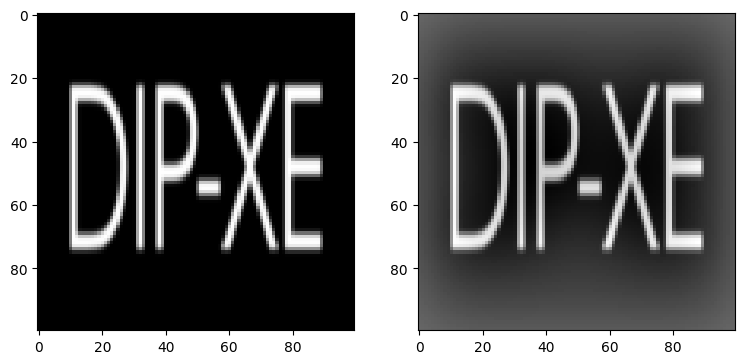

In [2]:
#code highpassfilter sử dụng kể thừa từ lowpassfilter
import numpy as np
import matplotlib.pyplot as plt
import cv2

class Frequency_LowpassFilter(object):
    def __init__(self,img) -> None:
        self.img=img
        M, N=self.img.shape
        self.P, self.Q = 2*M, 2*N

    def DFT1D(self,img):
        '''Biến đổi DFT đơn giản hoá theo Eq.14 trong slide'''
        U = len(img)
        outarry = np.zeros(U, dtype=complex)
        for v in range(U):
            sum = 0.0
            for n in range(U):
                e = np.exp(-1j * 2 * np.pi * v * n / U)
                sum += img[n] * e
            outarry[v] = sum
        return outarry
    
    def IDFT1D(self,img):
        '''
            Biến đổi ngược IDFT đơn giản hoá theo Eq.14 trong slide:
            f(u,y)=\frac{1}{N} \sum_{v=0}^{N-1} F(u,v) e^{j2 \pi vy/N}
        '''
        U = len(img)
        outarry = np.zeros(U,dtype=complex)
        for n in range(U):
            sum = 0.0
            for v in range(U):
                e = np.exp(1j * 2 * np.pi * v * n / U)
                sum += img[v]*e
            outarry[n]=sum/U
        return outarry
    ### khởi taoh kernel lọc ###
    def lowPass_Ideals(self,D0):
        '''Định nghĩa hàm lọc Ideals'''
        # H is our filter
        H = np.zeros((self.P, self.Q))
        D = np.zeros((self.P, self.Q))
        U0 = int(self.P / 2)
        V0 = int(self.Q / 2)
        # Tính khoảng cách từ điểm (u,v) đến tâm c
        for u in range(self.P):
            for v in range(self.Q):
                duc2 = np.power(u-U0, 2)
                dvc2 = np.power(v-V0, 2)
                D[u, v] = np.sqrt( duc2 + dvc2)
        # Tính bộ lọc
        for u in range(self.P):
            for v in range(self.Q):
                if D[u,v] <= D0:
                    H[u, v] = 1
                else:
                    H[u, v] = 0
        return H
    def lowPass_Butterworth(self, D0, n):
        '''Tạo bước 4, khởi tạo ma trận lọc Butterworth ở công thức 16 slide'''
        # H is our filter
        H = np.zeros((self.P, self.Q))
        D = np.zeros((self.P, self.Q))
        #tam cua anh trong mien tan so (U0, V0)
        U0 = int(self.P / 2)
        V0 = int(self.Q / 2)
        for u in range(self.P):
            for v in range(self.Q):
                duc2 = np.power(u-U0, 2)
                dvc2 = np.power(v-V0, 2)
                D[u, v] = np.sqrt( duc2 + dvc2)
        for u in range(self.P):
            for v in range(self.Q):
                H[u,v]=1.0/(1+D[u,v]/D0)**(2*n)
        return H
    def lowPass_Gaussian(self, D0):
        # Gaussian low-pass filter
        H = np.zeros((self.P, self.Q))
        U0 = self.P // 2
        V0 = self.Q // 2
        for u in range(self.P):
            for v in range(self.Q):
                Duv = np.sqrt((u - U0) ** 2 + (v - V0) ** 2)
                H[u, v] = np.exp(-(Duv ** 2) / (2 * (D0 ** 2)))
        return H
    def step_1(self):
        '''Bước 1: Mở rộng ảnh từ kích thước MxN vào ảnh PxQ với P=2M và Q=2N'''
        M, N=self.img.shape
        # Chuyển ảnh PxQ vào mảng fp
        f_xy_p = np.zeros((self.P, self.Q))
        f_xy_p[:M, :N] = self.img
        return f_xy_p
    
    def step_2(self,f_xy_p):
        '''Bước 2: Tạo ảnh F_xy_p: nhân ảnh fp(x,y) với (-1)_{x+y} để tạo ảnh mới'''
        F_xy_p = np.zeros((self.P, self.Q))
        for x in range(self.P):
            for y in range(self.Q):
                F_xy_p[x, y] = f_xy_p[x, y] * np.power(-1, x + y)
        return F_xy_p
    
    def step_3(self,F_xy_p):
        '''Bước 3: Tính DFT đơn giản cho ảnh F_xy_p trong miền tần'''
        dft_cot = dft_hang = np.zeros((self.P, self.Q),dtype=complex)
        # DFT cho hàng thứ i
        for i in range(self.P):
            dft_hang[i] = self.DFT1D(F_xy_p[i])
        # DFT cho cột thứ j
        for j in range(self.Q):
            dft_cot[:, j] = self.DFT1D(dft_hang[:, j])
        return dft_cot
    
    def step_67(self,G_uv):
        '''Biến đổi ngược IDFT với ảnh lọc G(u,v)'''
        # Bước 6.1 Thực hiện biến đổi ngược DFT
        idft_cot = idft_hang = np.zeros((self.P, self.Q),dtype=complex)
        # IDFT cho hàng thứ u
        for i in range(self.P):
            idft_hang[i] = self.IDFT1D(G_uv[i])
        # IDFT cho cột thứ v
        for j in range(self.Q):
            idft_cot[:, j] = self.IDFT1D(idft_hang[:, j])
        # Bước 6.2: Nhân phần thực ảnh sau khi biến đổi ngược với -1 mũ (x+y)
        g_xy_p=self.step_2(idft_cot.real)
        # Bước 7: Rút trích ảnh kích thước MxN từ ảnh PxQ
        # Và đây ảnh cuối cùng sau khi lọc
        g_xy = g_xy_p[:self.img.shape[0], :self.img.shape[1]]
        return g_xy 
       
    def ILPF(self,D0):
        '''Lọc ảnh trong miền tần số, sử dụng ILPF'''
        # Bước 4: Tạo bộ lọc
        H_uv=self.lowPass_Ideals(D0)
        # Tính F(u,v) trong miền tần số
        f_p=self.step_1()
        F_p=self.step_2(f_p)
        F_uv=self.step_3(F_p)
        # Bước 5: Nhân ảnh (elementwises) sau khi DFT với bộ lọc H để thu được G(u,v)
        G_uv=np.multiply(F_uv,H_uv)
        # Bước 67: Kết quả lọc
        g_p=self.step_67(G_uv)
        return g_p
    def BLPF(self, D0, n):
        '''Butterworth lowpass filter'''
        #bước 4: tạo bộ lọc butterworth
        H_uv=self.lowPass_Butterworth(D0, n)
        f_p=self.step_1()
        F_p=self.step_2(f_p)
        F_uv=self.step_3(F_p)
        G_uv=np.multiply(F_uv,H_uv)
        g_p=self.step_67(G_uv)
        return g_p
    def GLPF(self, D0):
        # Gaussian low-pass filter
        H_uv = self.lowPass_Gaussian(D0)
        f_p = self.step_1()
        F_p = self.step_2(f_p)
        F_uv = self.step_3(F_p)
        G_uv = np.multiply(F_uv, H_uv)
        g_p = self.step_67(G_uv)
        return g_p

class Frequency_HighpassFilter(Frequency_LowpassFilter): #lớp con kế thừa từ lớp lowpass
    def __init__(self, img) -> None:
        super().__init__(img)
### khởi taoh kernel lọc ###
### khởi taoh kernel lọc ###
    def highPass_Butterworth(self, D0, n):
        '''Tạo bước 4, khởi tạo ma trận lọc Butterworth ở công thức 16 slide'''
        # H is our filter
        H = np.zeros((self.P, self.Q)).astype(float)
        D = np.zeros((self.P, self.Q)).astype(float)
        #tam cua anh trong mien tan so (U0, V0)
        U0 = int(self.P / 2)
        V0 = int(self.Q / 2)
        for u in range(self.P):
            for v in range(self.Q):
                duc2 = np.power(u-U0, 2)
                dvc2 = np.power(v-V0, 2)
                D[u, v] = np.sqrt( duc2 + dvc2)
        for u in range(self.P):
            for v in range(self.Q):
                H[u,v]=1.0/(1+D0/D[u,v])**(2*n)
        return H
    def highPass_Gaussian(self, D0, n):
        '''Tạo bước 4, khởi tạo ma trận lọc Butterworth ở công thức 16 slide'''
        # H is our filter
        H = np.zeros((self.P, self.Q))
        D = np.zeros((self.P, self.Q))
        #tam cua anh trong mien tan so (U0, V0)
        U0 = int(self.P / 2)
        V0 = int(self.Q / 2)
        for u in range(self.P):
            for v in range(self.Q):
                duc2 = np.power(u-U0, 2)
                dvc2 = np.power(v-V0, 2)
                D[u, v] = np.sqrt( duc2 + dvc2)
        for u in range(self.P):
            for v in range(self.Q):
                H[u,v]=1 - np.exp(-np.power(D[u,v],2)/(2*np.power(D0,2)))
        return H
    def step_1(self):
        '''Bước 1: Mở rộng ảnh từ kích thước MxN vào ảnh PxQ với P=2M và Q=2N'''
        M, N=self.img.shape
        # Chuyển ảnh PxQ vào mảng fp
        f_xy_p = np.zeros((self.P, self.Q))
        f_xy_p[:M, :N] = self.img
        return f_xy_p
    
    def step_2(self,f_xy_p):
        '''Bước 2: Tạo ảnh F_xy_p: nhân ảnh fp(x,y) với (-1)_{x+y} để tạo ảnh mới'''
        F_xy_p = np.zeros((self.P, self.Q))
        for x in range(self.P):
            for y in range(self.Q):
                F_xy_p[x, y] = f_xy_p[x, y] * np.power(-1, x + y)
        return F_xy_p
    
    def step_3(self,F_xy_p):
        '''Bước 3: Tính DFT đơn giản cho ảnh F_xy_p trong miền tần'''
        dft_cot = dft_hang = np.zeros((self.P, self.Q),dtype=complex)
        # DFT cho hàng thứ i
        for i in range(self.P):
            dft_hang[i] = self.DFT1D(F_xy_p[i])
        # DFT cho cột thứ j
        for j in range(self.Q):
            dft_cot[:, j] = self.DFT1D(dft_hang[:, j])
        return dft_cot
    
    def step_67(self,G_uv):
        '''Biến đổi ngược IDFT với ảnh lọc G(u,v)'''
        # Bước 6.1 Thực hiện biến đổi ngược DFT
        idft_cot = idft_hang = np.zeros((self.P, self.Q),dtype=complex)
        # IDFT cho hàng thứ u
        for i in range(self.P):
            idft_hang[i] = self.IDFT1D(G_uv[i])
        # IDFT cho cột thứ v
        for j in range(self.Q):
            idft_cot[:, j] = self.IDFT1D(idft_hang[:, j])
        # Bước 6.2: Nhân phần thực ảnh sau khi biến đổi ngược với -1 mũ (x+y)
        g_xy_p=self.step_2(idft_cot.real)
        # Bước 7: Rút trích ảnh kích thước MxN từ ảnh PxQ
        # Và đây ảnh cuối cùng sau khi lọc
        g_xy = g_xy_p[:self.img.shape[0], :self.img.shape[1]]
        return g_xy 
       
    def ILPF(self,D0):
        '''Lọc ảnh trong miền tần số, sử dụng ILPF'''
        # Bước 4: Tạo bộ lọc
        H_uv=self.lowPass_Ideals(D0)
        # Tính F(u,v) trong miền tần số
        f_p=self.step_1()
        F_p=self.step_2(f_p)
        F_uv=self.step_3(F_p)
        # Bước 5: Nhân ảnh (elementwises) sau khi DFT với bộ lọc H để thu được G(u,v)
        G_uv=np.multiply(F_uv,H_uv)
        # Bước 67: Kết quả lọc
        g_p=self.step_67(G_uv)
        return g_p
    def BHPF(self, D0, n):
        '''Butterworth lowpass filter'''
        #bước 4: tạo bộ lọc butterworth
        H_uv=self.highPass_Butterworth(D0, n)
        f_p=self.step_1()
        F_p=self.step_2(f_p)
        F_uv=self.step_3(F_p)
        G_uv=np.multiply(F_uv,H_uv)
        g_p=self.step_67(G_uv)
        return g_p
    def GHPF(self, D0, n):
        '''Butterworth lowpass filter'''
        #bước 4: tạo bộ lọc butterworth
        H_uv=self.highPass_Gaussian(D0, n)
        f_p=self.step_1()
        F_p=self.step_2(f_p)
        F_uv=self.step_3(F_p)
        G_uv=np.multiply(F_uv,H_uv)
        g_p=self.step_67(G_uv)
        return g_p
    

if __name__ == "__main__":
    image = cv2.imread("./dip.tif", 0).astype(float)
    #image=cv2.GaussianBlur(original,(3,3),10.0)
    image = cv2.resize(src=image, dsize=(100, 100))
    g_highpass=Frequency_HighpassFilter(image)
    g_img=g_highpass.GHPF(3,15)
    fig=plt.figure(figsize=(9,6))
    ax1,ax2=fig.subplots(1,2)
    ax1.imshow(image,cmap="gray")
    ax2.imshow(g_img,cmap="gray")
    plt.show()
